In [2]:
from __future__ import absolute_import, division, print_function

import pathlib

import os

# manually specify the GPUs to use
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import matplotlib as m
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tables

import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Conv1D
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler, ReduceLROnPlateau, CSVLogger, ModelCheckpoint, EarlyStopping
print(tf.__version__)

from scipy.io import readsav
from scipy.signal import deconvolve
from scipy.ndimage.interpolation import shift

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

#TURBO CHARGE YOUR PYTHON -- Make it parallel
import multiprocessing

2021-10-01 08:58:04.898597: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-10-01 08:58:04.898629: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.6.0


In [3]:
def convolve(signal, filterProfile): 

    return np.convolve(signal, filterProfile)

def customLoss(yTrue, yPred):

    #weights1 = K.constant(weights)
    #return K.mean(K.square(yTrue - yPred) * weights1)
    return K.mean(K.square(yTrue - yPred))

def customLoss_MP(yTrue, yPred):

    weights1 = K.constant(weights_MP)
    return K.mean(K.square(yTrue - yPred) * weights1)

def customLoss1(yTrue, yPred):

    weights11 = K.constant(weights[0:40])
    return K.mean(K.square(yTrue - yPred) * weights11)

In [4]:
def load_spectral_profiles(directory,filename):
    hdul     = fits.open(directory+filename)
    spectrum = hdul[0].data
    print(hdul.header)
    return spectrum 

def build_simple_model1():
  #build the NN needed for the problem accomodating a single
  #convolutional layer and two densely connected hidden layer
  kSzConv1D = 5
  waveNumd  = 232
  model = keras.Sequential([
    layers.Conv1D(50, (3,),
        activation='relu',strides=1,input_shape=[waveNumd,1]),
    layers.Conv1D(40, (3,),
        activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(25, (3,),
        activation='relu'),
    layers.Conv1D(15, (4,),
        activation='relu'),
    layers.MaxPooling1D(2),
    #layers.GlobalAveragePooling1D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(40,activation=tf.nn.relu),
    layers.Dense(40,activation=tf.nn.relu),  
    #layers.GlobalAveragePooling1D(),
    #layers.Dense(20, activation='sigmoid'),    
    #layers.Dense(10, activation='sigmoid'),
    layers.Dense(waveNumd)])
  optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
          beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  #optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1,
  #                                          initial_accumulator_value=0.1, epsilon=1e-07)


  model.compile(loss=customLoss,
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def build_conv_model():
  #build the NN needed for the problem accomodating a single
  #convolutional layer and two densely connected hidden layer
  kSzConv1D = 5
  waveNumd  = 232
  model = keras.Sequential([
    layers.Conv1D(15, (3,),
        activation='relu', strides=1, input_shape=[waveNumd, 1]),
    layers.Conv1D(30, (5,),
        activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(15, (3,),
        activation='relu'),
    layers.Conv1D(25, (3,),
        activation='relu'),
    #layers.MaxPooling1D(2),
    #layers.GlobalAveragePooling1D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    #layers.Dense(30,activation=tf.nn.relu),
    layers.Dense(30,activation=tf.nn.relu),  
    #layers.GlobalAveragePooling1D(),
    #layers.Dense(20, activation='sigmoid'),    
    #layers.Dense(10, activation='sigmoid'),
    layers.Dense(waveNumd)])
  optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
          beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  #optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1,
  #                                          initial_accumulator_value=0.1, epsilon=1e-07)
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def build_conv_model2():
    #build the NN needed for the problem accomodating a single
    #convolutional layer and two densely connected hidden layer
    kSzConv1D = 3
    waveNumd  = 232
    y1 = layers.Input(shape=[waveNumd,1])
    y = layers.Conv1D(5, (kSzConv1D, ), activation='relu')(y1)
    y = layers.MaxPooling1D(2)(y)
    y = layers.Conv1D(10, (kSzConv1D, ), activation='relu')(y)
    y = layers.MaxPooling1D(2)(y)
    y = layers.Conv1D(20, (kSzConv1D, ), activation='relu')(y)
    y = layers.MaxPooling1D(2)(y)
    #y = layers.Dense(100,activation='relu')(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(20, (kSzConv1D, ), activation='relu')(y)
    #y = layers.Dropout(0.2)(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(10, (kSzConv1D, ), activation='relu')(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(5, (kSzConv1D, ), activation='relu')(y)
    #layers.GlobalAveragePooling1D(),
    #y = layers.Flatten()(y)
    #y = layers.Dropout(0.5)(y)
    y = layers.Flatten()(y)
    y = layers.Dense(waveNumd, activation=tf.nn.relu)(y)
    y2 = layers.Add()([y, y1[:,  :, 0]])
    y = layers.Dense(waveNumd, activation=tf.nn.relu)(y2)

    #layers.GlobalAveragePooling1D(),
    #layers.Dense(20, activation='sigmoid'),    
    #layers.Dense(10, activation='sigmoid'),
    
    x = layers.Dense(waveNumd, activation='linear')(y2)
    optimizer = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9,
            beta_2=0.999, epsilon=None, decay=1.0, amsgrad=False)
    model = keras.models.Model(inputs=y1, outputs=x)
    model.compile(loss='mean_squared_error', optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

def build_conv_model_MP(waveNumd, ratio):
    '''
    build the NN needed for the problem accomodating a single
    convolutional layer and two densely connected hidden layer
    '''
    kSzConv1D = 3
    # waveNumd  = 40
    
    y1 = layers.Input(shape=[int(waveNumd/ratio),1])
    y = layers.Conv1D(5,  (kSzConv1D, ))(y1)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    y = layers.MaxPooling1D(2)(y)
    y = layers.Conv1D(10, (kSzConv1D, ))(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    y = layers.MaxPooling1D(2)(y)
    #y = layers.Conv1D(20, (kSzConv1D,), activation='relu')(y)
    #y = layers.MaxPooling1D(2)(y)
    # y = layers.Conv1D(20, (kSzConv1D, ), activation='relu')(y)
    # y = layers.Dense(waveNumd,activation='relu')(y)
    #y = layers.UpSampling1D()(y)
    #y = layers.Conv1D(20,(kSzConv1D,), activation='relu')(y)
    # y = layers.Dropout(0.2)(y)
    # y = layers.Dropout(0.2)(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(10,(kSzConv1D,))(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(5,(kSzConv1D,))(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    # layers.GlobalAveragePooling1D(),
    # y = layers.Flatten()(y)
    y = layers.Flatten()(y)
    # y = layers.Dense(waveNumd, activation='sigmoid')(y)
    x = layers.Dense(waveNumd,activation='linear')(y)
    
    optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
            beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model2 = keras.models.Model(inputs=y1, outputs=x)
    model2.compile(loss=customLoss_MP,
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])

    return model2

def build_dense_model():
    waveNumd  = 100
    numDense1 = 256
    y1 = layers.Input(shape=[waveNumd,1])
    y = layers.Flatten()(y1)
    y = layers.Dense(numDense1,activation='relu')(y)
    #y = layers.Dense(numDense1,activation='relu')(y)
    y = layers.Dense(numDense1,activation='relu')(y)
    y = layers.Dropout(0.2)(y)
    y = layers.Dense(numDense1,activation='relu')(y)
    y = layers.Dense(numDense1,activation='relu')(y)
    #y = layers.Dense(256,activation='relu')(y)
    #y = layers.Flatten()(y)
    y = layers.Dense(waveNumd,activation='sigmoid')(y)
    y = layers.Add()([y,y1[:,:,0]])
    x = layers.Dense(waveNumd,activation='linear')(y)
    
    optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
            beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model = keras.models.Model(inputs=y1, outputs=x)
    model.compile(loss=customLoss,
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    
    return model 


In [5]:
def Lorentzian(x0,x,gamma):
    x2  = (x0-x)*(x0-x)
    exp = gamma/(np.pi*(x2+gamma*gamma))
    return exp


def Gaussian(x,mu,sigma):
    return np.exp((-1)*(x-mu)*(x-mu)/(2*sigma*sigma))/np.sqrt(2*np.pi*sigma*sigma)

In [6]:
data = pd.read_hdf('test2.h5')

In [7]:
trace1=np.array([x for x in data['Trace1']]).reshape(-1,232,1).astype('float32')
trace2=np.array([x for x in data['Trace2']]).reshape(-1,232,1).astype('float32')
traceFinal=np.array([x for x in data['TraceFinal']]).reshape(-1,232,1).astype('float32')

In [8]:
# train, validation, test
train = 0.8
val = 0.1
test = 1-train-val

assert train+val+test==1.0

trace1_train = trace1[:int(len(trace1)*train)]
trace1_val = trace1[int(len(trace1)*train):int(len(trace1)*train)+int(len(trace1)*val)]
trace1_test = trace1[int(len(trace1)*train)+int(len(trace1)*val):]

trace2_train = trace2[:int(len(trace2)*train)]
trace2_val = trace2[int(len(trace2)*train):int(len(trace2)*train)+int(len(trace2)*val)]
trace2_test = trace2[int(len(trace2)*train)+int(len(trace2)*val):]

traceFinal_train = traceFinal[:int(len(traceFinal)*train)]
traceFinal_val = traceFinal[int(len(traceFinal)*train):int(len(traceFinal)*train)+int(len(traceFinal)*val)]
traceFinal_test = traceFinal[int(len(traceFinal)*train)+int(len(traceFinal)*val):]

2021-10-01 08:58:19.907073: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-10-01 08:58:19.907318: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-10-01 08:58:19.907514: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/loca

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 232, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 230, 5)       20          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 115, 5)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 113, 10)      160         max_pooling1d[0][0]              
______________________________________________________________________________________________

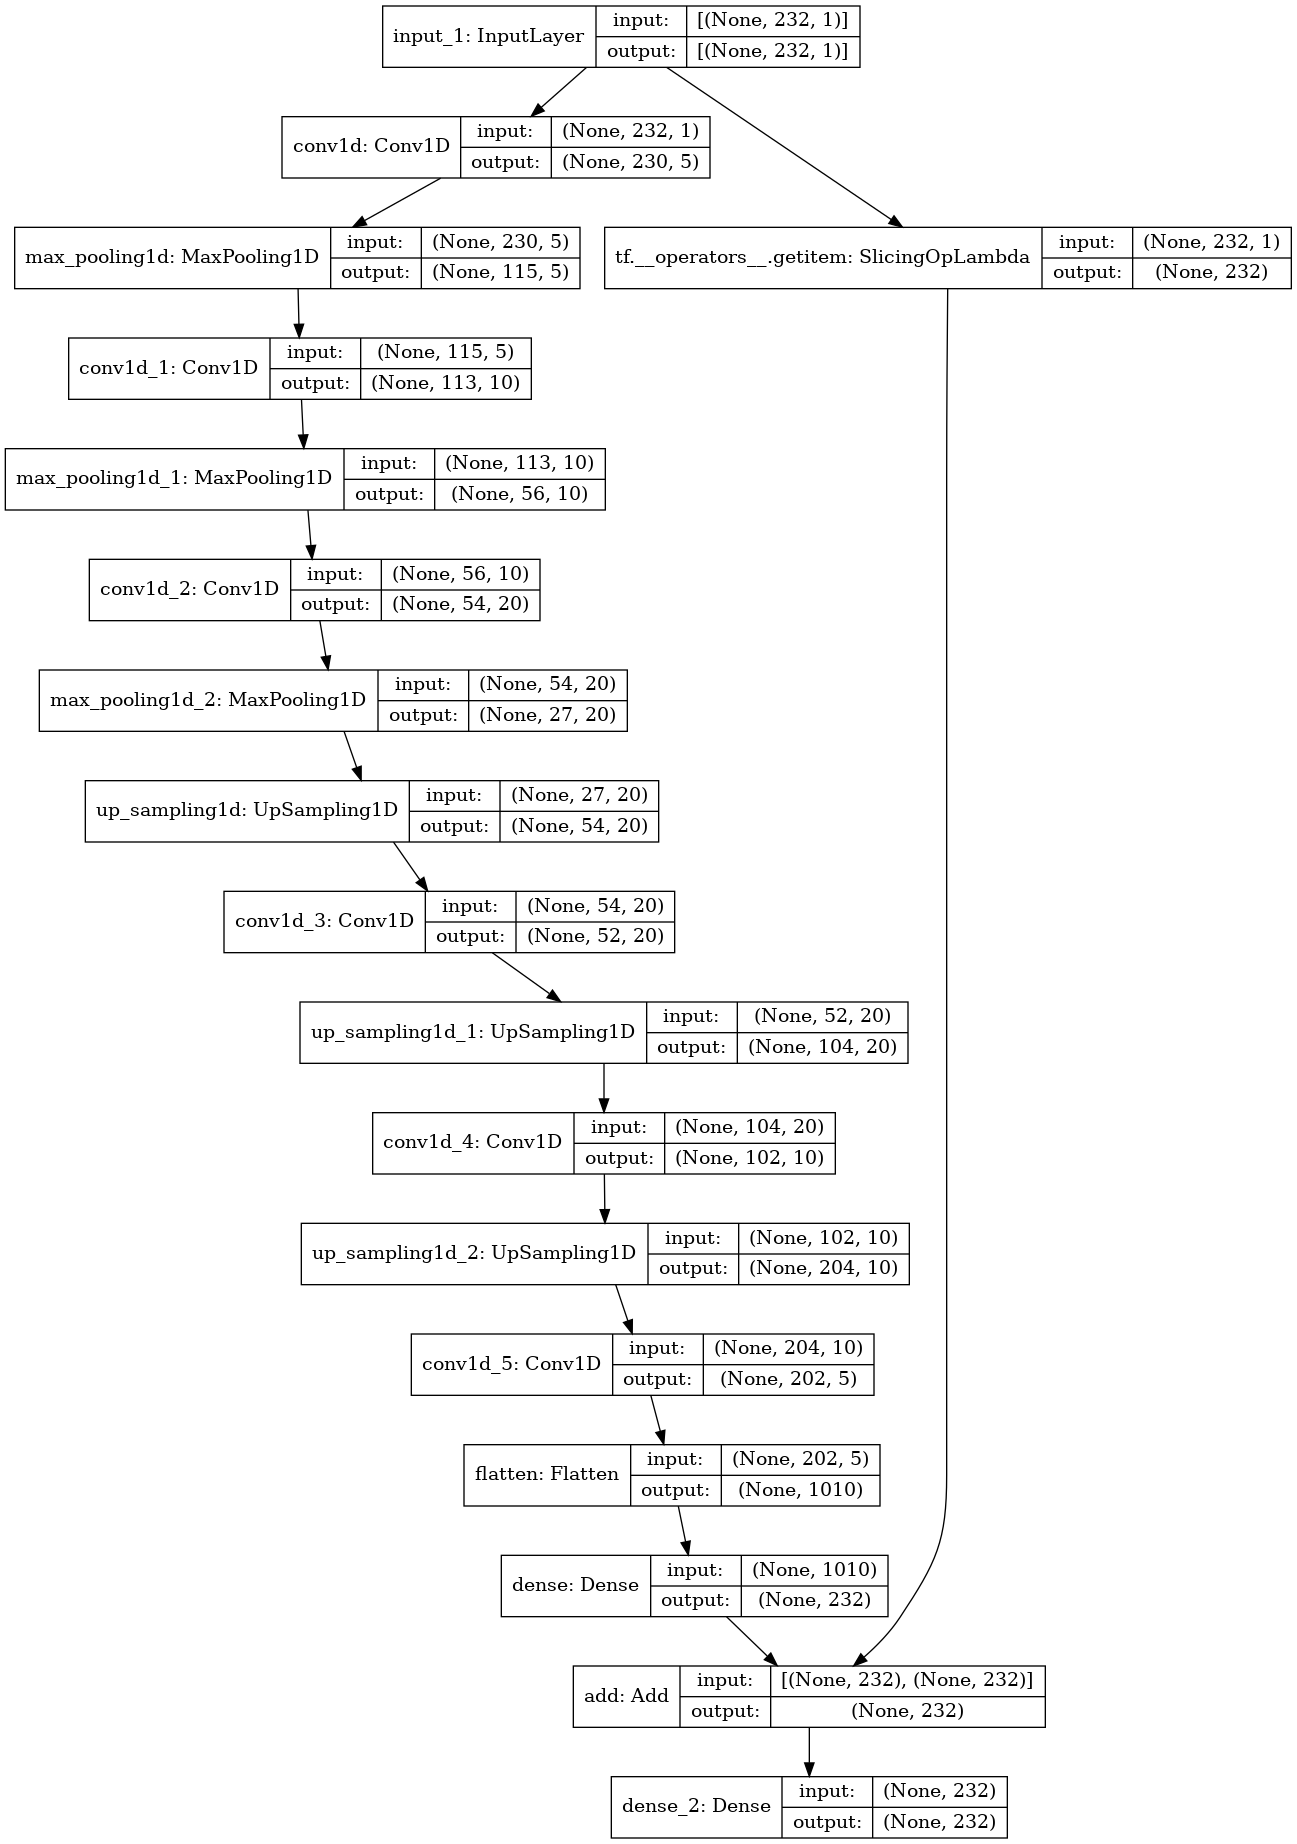

In [9]:
from IPython.display import Image 

#model1 = build_simple_model1()
model = build_conv_model2()
model.summary()
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True)
#Image('model.png')

In [ ]:
EPOCHS = 5000
optimizer = 'Adam'
#optimizer = 'SGD'

if optimizer == 'Adam':
    model.optimizer = tf.keras.optimizers.Adam(lr=1e-1, beta_1=0.9,
              beta_2=0.999, epsilon=1e-8, decay=1.0, amsgrad=False)

if optimizer == 'SGD': 
    model.optimizer = tf.keras.optimizers.SGD(lr=1, nesterov=True)

checkpoint = ModelCheckpoint("models/model", monitor="val_mean_squared_error", verbose=1, save_best_only=True, 
                             mode='min', save_freq='epoch')

early_stopping = EarlyStopping(monitor="val_mean_squared_error", patience=50, mode='min')


history = model.fit(trace1_train,
                     traceFinal_train,
                     validation_data=(trace1_val, traceFinal_val),
                     callbacks=[early_stopping, checkpoint],
                     epochs=EPOCHS, validation_split=0.20, verbose=1)

2021-08-25 13:37:18.847279: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5000
5400/5400 [==============================] - 60s 11ms/step - loss: 86051568.0000 - mean_absolute_error: 623.5539 - mean_squared_error: 86051568.0000 - val_loss: 79052.0156 - val_mean_absolute_error: 121.4291 - val_mean_squared_error: 79052.0156

Epoch 00001: val_mean_squared_error improved from inf to 79052.01562, saving model to models/model


2021-08-25 13:38:19.880772: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/model/assets
Epoch 2/5000
  19/5400 [..............................] - ETA: 49s - loss: 133349.2188 - mean_absolute_error: 145.6206 - mean_squared_error: 133349.2188

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 58s 11ms/step - loss: 120725.3672 - mean_absolute_error: 138.9384 - mean_squared_error: 120725.3672 - val_loss: 73573.9609 - val_mean_absolute_error: 111.0146 - val_mean_squared_error: 73573.9609

Epoch 00002: val_mean_squared_error improved from 79052.01562 to 73573.96094, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 3/5000
  16/5400 [..............................] - ETA: 57s - loss: 75538.3281 - mean_absolute_error: 120.5827 - mean_squared_error: 75538.3281

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 103152.4062 - mean_absolute_error: 122.6855 - mean_squared_error: 103152.4062 - val_loss: 65389.4805 - val_mean_absolute_error: 91.7888 - val_mean_squared_error: 65389.4805

Epoch 00003: val_mean_squared_error improved from 73573.96094 to 65389.48047, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 4/5000
  17/5400 [..............................] - ETA: 55s - loss: 98327.7344 - mean_absolute_error: 108.8775 - mean_squared_error: 98327.7344  

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 87007.6641 - mean_absolute_error: 100.9149 - mean_squared_error: 87007.6641 - val_loss: 60660.3203 - val_mean_absolute_error: 78.6978 - val_mean_squared_error: 60660.3203

Epoch 00004: val_mean_squared_error improved from 65389.48047 to 60660.32031, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 5/5000
  17/5400 [..............................] - ETA: 54s - loss: 80181.4375 - mean_absolute_error: 90.7385 - mean_squared_error: 80181.4375

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 79157.1328 - mean_absolute_error: 88.5153 - mean_squared_error: 79157.1328 - val_loss: 58424.3555 - val_mean_absolute_error: 68.8725 - val_mean_squared_error: 58424.3555

Epoch 00005: val_mean_squared_error improved from 60660.32031 to 58424.35547, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 6/5000
  16/5400 [..............................] - ETA: 55s - loss: 79838.7188 - mean_absolute_error: 80.7252 - mean_squared_error: 79838.7188

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 74944.6328 - mean_absolute_error: 81.6693 - mean_squared_error: 74944.6328 - val_loss: 57129.4766 - val_mean_absolute_error: 67.1742 - val_mean_squared_error: 57129.4766

Epoch 00006: val_mean_squared_error improved from 58424.35547 to 57129.47656, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 7/5000
  18/5400 [..............................] - ETA: 52s - loss: 62309.0000 - mean_absolute_error: 80.2377 - mean_squared_error: 62309.0000

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 58s 11ms/step - loss: 72213.1406 - mean_absolute_error: 77.3497 - mean_squared_error: 72213.1406 - val_loss: 56023.5430 - val_mean_absolute_error: 63.8519 - val_mean_squared_error: 56023.5430

Epoch 00007: val_mean_squared_error improved from 57129.47656 to 56023.54297, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 8/5000
  18/5400 [..............................] - ETA: 53s - loss: 65241.5820 - mean_absolute_error: 72.3805 - mean_squared_error: 65241.5820

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 70187.8281 - mean_absolute_error: 74.2666 - mean_squared_error: 70187.8281 - val_loss: 55414.8672 - val_mean_absolute_error: 61.9924 - val_mean_squared_error: 55414.8672

Epoch 00008: val_mean_squared_error improved from 56023.54297 to 55414.86719, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 9/5000
  12/5400 [..............................] - ETA: 53s - loss: 50383.1523 - mean_absolute_error: 74.4336 - mean_squared_error: 50383.1523

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 68608.7969 - mean_absolute_error: 71.9506 - mean_squared_error: 68608.7969 - val_loss: 54876.8789 - val_mean_absolute_error: 61.5306 - val_mean_squared_error: 54876.8789

Epoch 00009: val_mean_squared_error improved from 55414.86719 to 54876.87891, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 10/5000
  11/5400 [..............................] - ETA: 55s - loss: 63141.7617 - mean_absolute_error: 68.1143 - mean_squared_error: 63141.7617

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 67304.6484 - mean_absolute_error: 70.1115 - mean_squared_error: 67304.6484 - val_loss: 54270.3125 - val_mean_absolute_error: 61.1553 - val_mean_squared_error: 54270.3125

Epoch 00010: val_mean_squared_error improved from 54876.87891 to 54270.31250, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 11/5000
  16/5400 [..............................] - ETA: 55s - loss: 66061.3359 - mean_absolute_error: 69.4435 - mean_squared_error: 66061.3359

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 66209.1953 - mean_absolute_error: 68.5703 - mean_squared_error: 66209.1953 - val_loss: 53886.9375 - val_mean_absolute_error: 58.9752 - val_mean_squared_error: 53886.9375

Epoch 00011: val_mean_squared_error improved from 54270.31250 to 53886.93750, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 12/5000
  16/5400 [..............................] - ETA: 54s - loss: 71813.0469 - mean_absolute_error: 69.7393 - mean_squared_error: 71813.0469

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 65263.7695 - mean_absolute_error: 67.2630 - mean_squared_error: 65263.7695 - val_loss: 53694.2031 - val_mean_absolute_error: 57.9776 - val_mean_squared_error: 53694.2031

Epoch 00012: val_mean_squared_error improved from 53886.93750 to 53694.20312, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 13/5000
  18/5400 [..............................] - ETA: 50s - loss: 64422.3750 - mean_absolute_error: 67.9343 - mean_squared_error: 64422.3750

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 64437.4531 - mean_absolute_error: 66.1374 - mean_squared_error: 64437.4531 - val_loss: 53256.4844 - val_mean_absolute_error: 56.8864 - val_mean_squared_error: 53256.4844

Epoch 00013: val_mean_squared_error improved from 53694.20312 to 53256.48438, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 14/5000
  17/5400 [..............................] - ETA: 54s - loss: 75549.6875 - mean_absolute_error: 65.9658 - mean_squared_error: 75549.6875

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 63704.5977 - mean_absolute_error: 65.1556 - mean_squared_error: 63704.5977 - val_loss: 53070.9688 - val_mean_absolute_error: 57.1740 - val_mean_squared_error: 53070.9688

Epoch 00014: val_mean_squared_error improved from 53256.48438 to 53070.96875, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 15/5000
  11/5400 [..............................] - ETA: 58s - loss: 68137.4844 - mean_absolute_error: 66.3039 - mean_squared_error: 68137.4844 

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 63054.8750 - mean_absolute_error: 64.3089 - mean_squared_error: 63054.8750 - val_loss: 52832.1914 - val_mean_absolute_error: 56.5500 - val_mean_squared_error: 52832.1914

Epoch 00015: val_mean_squared_error improved from 53070.96875 to 52832.19141, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 16/5000
  12/5400 [..............................] - ETA: 53s - loss: 75864.8750 - mean_absolute_error: 64.6563 - mean_squared_error: 75864.8750

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 62471.1172 - mean_absolute_error: 63.5516 - mean_squared_error: 62471.1172 - val_loss: 52416.6992 - val_mean_absolute_error: 55.0848 - val_mean_squared_error: 52416.6992

Epoch 00016: val_mean_squared_error improved from 52832.19141 to 52416.69922, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 17/5000
  17/5400 [..............................] - ETA: 54s - loss: 62981.1836 - mean_absolute_error: 62.7835 - mean_squared_error: 62981.1836

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 61943.1953 - mean_absolute_error: 62.8884 - mean_squared_error: 61943.1953 - val_loss: 52348.1523 - val_mean_absolute_error: 55.3305 - val_mean_squared_error: 52348.1523

Epoch 00017: val_mean_squared_error improved from 52416.69922 to 52348.15234, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 18/5000
  18/5400 [..............................] - ETA: 52s - loss: 60539.3906 - mean_absolute_error: 63.4132 - mean_squared_error: 60539.3906

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 61460.8008 - mean_absolute_error: 62.2930 - mean_squared_error: 61460.8008 - val_loss: 52172.8594 - val_mean_absolute_error: 55.2916 - val_mean_squared_error: 52172.8594

Epoch 00018: val_mean_squared_error improved from 52348.15234 to 52172.85938, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 19/5000
  13/5400 [..............................] - ETA: 52s - loss: 90381.2656 - mean_absolute_error: 65.5307 - mean_squared_error: 90381.2656

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 61023.8516 - mean_absolute_error: 61.7684 - mean_squared_error: 61023.8516 - val_loss: 51926.8672 - val_mean_absolute_error: 55.1107 - val_mean_squared_error: 51926.8672

Epoch 00019: val_mean_squared_error improved from 52172.85938 to 51926.86719, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 20/5000
  12/5400 [..............................] - ETA: 53s - loss: 82806.5391 - mean_absolute_error: 65.1930 - mean_squared_error: 82806.5391

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 60616.8828 - mean_absolute_error: 61.2735 - mean_squared_error: 60616.8828 - val_loss: 51756.8398 - val_mean_absolute_error: 54.7986 - val_mean_squared_error: 51756.8398

Epoch 00020: val_mean_squared_error improved from 51926.86719 to 51756.83984, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 21/5000
  17/5400 [..............................] - ETA: 54s - loss: 60588.1211 - mean_absolute_error: 61.7470 - mean_squared_error: 60588.1211

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 60240.3906 - mean_absolute_error: 60.8405 - mean_squared_error: 60240.3906 - val_loss: 51554.5703 - val_mean_absolute_error: 53.8178 - val_mean_squared_error: 51554.5703

Epoch 00021: val_mean_squared_error improved from 51756.83984 to 51554.57031, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 22/5000
  17/5400 [..............................] - ETA: 54s - loss: 70106.9219 - mean_absolute_error: 62.1475 - mean_squared_error: 70106.9219

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 59892.1914 - mean_absolute_error: 60.4394 - mean_squared_error: 59892.1914 - val_loss: 51512.6758 - val_mean_absolute_error: 53.6902 - val_mean_squared_error: 51512.6758

Epoch 00022: val_mean_squared_error improved from 51554.57031 to 51512.67578, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 23/5000
  12/5400 [..............................] - ETA: 53s - loss: 58404.3633 - mean_absolute_error: 61.9390 - mean_squared_error: 58404.3633

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 59568.8242 - mean_absolute_error: 60.0726 - mean_squared_error: 59568.8242 - val_loss: 51386.8555 - val_mean_absolute_error: 53.3247 - val_mean_squared_error: 51386.8555

Epoch 00023: val_mean_squared_error improved from 51512.67578 to 51386.85547, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 24/5000
  18/5400 [..............................] - ETA: 51s - loss: 77266.2266 - mean_absolute_error: 61.5406 - mean_squared_error: 77266.2266

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 58s 11ms/step - loss: 59268.2305 - mean_absolute_error: 59.7341 - mean_squared_error: 59268.2305 - val_loss: 51303.8477 - val_mean_absolute_error: 53.6681 - val_mean_squared_error: 51303.8477

Epoch 00024: val_mean_squared_error improved from 51386.85547 to 51303.84766, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 25/5000
  17/5400 [..............................] - ETA: 54s - loss: 51172.9492 - mean_absolute_error: 58.7003 - mean_squared_error: 51172.9492

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 58984.9961 - mean_absolute_error: 59.4266 - mean_squared_error: 58984.9961 - val_loss: 51142.6914 - val_mean_absolute_error: 53.4831 - val_mean_squared_error: 51142.6914

Epoch 00025: val_mean_squared_error improved from 51303.84766 to 51142.69141, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 26/5000
  12/5400 [..............................] - ETA: 54s - loss: 57966.8125 - mean_absolute_error: 57.7043 - mean_squared_error: 57966.8125

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 58722.6055 - mean_absolute_error: 59.1316 - mean_squared_error: 58722.6055 - val_loss: 51010.1523 - val_mean_absolute_error: 53.0139 - val_mean_squared_error: 51010.1523

Epoch 00026: val_mean_squared_error improved from 51142.69141 to 51010.15234, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 27/5000
  12/5400 [..............................] - ETA: 53s - loss: 66079.5625 - mean_absolute_error: 59.5449 - mean_squared_error: 66079.5625

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 58470.8398 - mean_absolute_error: 58.8588 - mean_squared_error: 58470.8398 - val_loss: 51030.6680 - val_mean_absolute_error: 53.8145 - val_mean_squared_error: 51030.6680

Epoch 00027: val_mean_squared_error did not improve from 51010.15234
Epoch 28/5000
5400/5400 [==============================] - 59s 11ms/step - loss: 58235.4844 - mean_absolute_error: 58.6135 - mean_squared_error: 58235.4844 - val_loss: 50769.0430 - val_mean_absolute_error: 52.2761 - val_mean_squared_error: 50769.0430

Epoch 00028: val_mean_squared_error improved from 51010.15234 to 50769.04297, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 29/5000
  16/5400 [..............................] - ETA: 53s - loss: 52767.5977 - mean_absolute_error: 57.0637 - mean_squared_error: 52767.5977

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 58012.9883 - mean_absolute_error: 58.3727 - mean_squared_error: 58012.9883 - val_loss: 50724.6445 - val_mean_absolute_error: 52.4026 - val_mean_squared_error: 50724.6445

Epoch 00029: val_mean_squared_error improved from 50769.04297 to 50724.64453, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 30/5000
  12/5400 [..............................] - ETA: 53s - loss: 57827.0156 - mean_absolute_error: 57.6040 - mean_squared_error: 57827.0156

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 57805.0508 - mean_absolute_error: 58.1524 - mean_squared_error: 57805.0508 - val_loss: 50702.2344 - val_mean_absolute_error: 52.5469 - val_mean_squared_error: 50702.2344

Epoch 00030: val_mean_squared_error improved from 50724.64453 to 50702.23438, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 31/5000
  12/5400 [..............................] - ETA: 54s - loss: 58461.1914 - mean_absolute_error: 58.4921 - mean_squared_error: 58461.1914

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 57604.0547 - mean_absolute_error: 57.9471 - mean_squared_error: 57604.0547 - val_loss: 50559.3008 - val_mean_absolute_error: 52.3294 - val_mean_squared_error: 50559.3008

Epoch 00031: val_mean_squared_error improved from 50702.23438 to 50559.30078, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 32/5000
  18/5400 [..............................] - ETA: 52s - loss: 52533.2578 - mean_absolute_error: 57.3644 - mean_squared_error: 52533.2578

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 57414.5898 - mean_absolute_error: 57.7584 - mean_squared_error: 57414.5898 - val_loss: 50530.7656 - val_mean_absolute_error: 51.5138 - val_mean_squared_error: 50530.7656

Epoch 00032: val_mean_squared_error improved from 50559.30078 to 50530.76562, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 33/5000
  18/5400 [..............................] - ETA: 53s - loss: 58474.4453 - mean_absolute_error: 57.7130 - mean_squared_error: 58474.4453

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 57234.8047 - mean_absolute_error: 57.5532 - mean_squared_error: 57234.8047 - val_loss: 50447.1875 - val_mean_absolute_error: 52.3081 - val_mean_squared_error: 50447.1875

Epoch 00033: val_mean_squared_error improved from 50530.76562 to 50447.18750, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 34/5000
  13/5400 [..............................] - ETA: 52s - loss: 55233.6719 - mean_absolute_error: 57.8689 - mean_squared_error: 55233.6719

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 57064.4453 - mean_absolute_error: 57.3917 - mean_squared_error: 57064.4453 - val_loss: 50414.6836 - val_mean_absolute_error: 52.1647 - val_mean_squared_error: 50414.6836

Epoch 00034: val_mean_squared_error improved from 50447.18750 to 50414.68359, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 35/5000
  13/5400 [..............................] - ETA: 53s - loss: 47764.3125 - mean_absolute_error: 56.5955 - mean_squared_error: 47764.3125

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 56899.7148 - mean_absolute_error: 57.2322 - mean_squared_error: 56899.7148 - val_loss: 50288.9609 - val_mean_absolute_error: 51.6270 - val_mean_squared_error: 50288.9609

Epoch 00035: val_mean_squared_error improved from 50414.68359 to 50288.96094, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 36/5000
  13/5400 [..............................] - ETA: 51s - loss: 58097.3320 - mean_absolute_error: 58.2040 - mean_squared_error: 58097.3320 

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 56743.4492 - mean_absolute_error: 57.0723 - mean_squared_error: 56743.4492 - val_loss: 50196.8008 - val_mean_absolute_error: 51.5437 - val_mean_squared_error: 50196.8008

Epoch 00036: val_mean_squared_error improved from 50288.96094 to 50196.80078, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 37/5000
  18/5400 [..............................] - ETA: 52s - loss: 70362.5391 - mean_absolute_error: 59.3007 - mean_squared_error: 70362.5391

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 56592.5352 - mean_absolute_error: 56.9258 - mean_squared_error: 56592.5352 - val_loss: 50166.3359 - val_mean_absolute_error: 51.0923 - val_mean_squared_error: 50166.3359

Epoch 00037: val_mean_squared_error improved from 50196.80078 to 50166.33594, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 38/5000
  17/5400 [..............................] - ETA: 53s - loss: 51585.4102 - mean_absolute_error: 56.9963 - mean_squared_error: 51585.4102

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 56448.5352 - mean_absolute_error: 56.7816 - mean_squared_error: 56448.5352 - val_loss: 50116.5586 - val_mean_absolute_error: 51.2020 - val_mean_squared_error: 50116.5586

Epoch 00038: val_mean_squared_error improved from 50166.33594 to 50116.55859, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 39/5000
  13/5400 [..............................] - ETA: 49s - loss: 52534.3555 - mean_absolute_error: 54.0346 - mean_squared_error: 52534.3555

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 56311.5078 - mean_absolute_error: 56.6462 - mean_squared_error: 56311.5078 - val_loss: 50047.0469 - val_mean_absolute_error: 51.3796 - val_mean_squared_error: 50047.0469

Epoch 00039: val_mean_squared_error improved from 50116.55859 to 50047.04688, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 40/5000
  16/5400 [..............................] - ETA: 55s - loss: 46084.9609 - mean_absolute_error: 55.2348 - mean_squared_error: 46084.9609

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 56179.4062 - mean_absolute_error: 56.5137 - mean_squared_error: 56179.4062 - val_loss: 50021.0781 - val_mean_absolute_error: 52.0049 - val_mean_squared_error: 50021.0781

Epoch 00040: val_mean_squared_error improved from 50047.04688 to 50021.07812, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 41/5000
  16/5400 [..............................] - ETA: 54s - loss: 47263.8906 - mean_absolute_error: 55.6084 - mean_squared_error: 47263.8906

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 56051.9531 - mean_absolute_error: 56.4103 - mean_squared_error: 56051.9531 - val_loss: 49945.8008 - val_mean_absolute_error: 51.2278 - val_mean_squared_error: 49945.8008

Epoch 00041: val_mean_squared_error improved from 50021.07812 to 49945.80078, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 42/5000
  12/5400 [..............................] - ETA: 55s - loss: 46223.2383 - mean_absolute_error: 53.4403 - mean_squared_error: 46223.2383

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 55930.5586 - mean_absolute_error: 56.2866 - mean_squared_error: 55930.5586 - val_loss: 49902.1445 - val_mean_absolute_error: 51.4288 - val_mean_squared_error: 49902.1445

Epoch 00042: val_mean_squared_error improved from 49945.80078 to 49902.14453, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 43/5000
  12/5400 [..............................] - ETA: 53s - loss: 70924.8438 - mean_absolute_error: 59.3174 - mean_squared_error: 70924.8438 

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 55812.6328 - mean_absolute_error: 56.1792 - mean_squared_error: 55812.6328 - val_loss: 49868.6562 - val_mean_absolute_error: 51.3820 - val_mean_squared_error: 49868.6562

Epoch 00043: val_mean_squared_error improved from 49902.14453 to 49868.65625, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 44/5000
  13/5400 [..............................] - ETA: 53s - loss: 63019.9609 - mean_absolute_error: 57.2391 - mean_squared_error: 63019.9609

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 55698.6797 - mean_absolute_error: 56.0789 - mean_squared_error: 55698.6797 - val_loss: 49784.1953 - val_mean_absolute_error: 50.9789 - val_mean_squared_error: 49784.1953

Epoch 00044: val_mean_squared_error improved from 49868.65625 to 49784.19531, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 45/5000
  16/5400 [..............................] - ETA: 54s - loss: 50297.8164 - mean_absolute_error: 54.3185 - mean_squared_error: 50297.8164

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 55588.5352 - mean_absolute_error: 55.9756 - mean_squared_error: 55588.5352 - val_loss: 49760.1289 - val_mean_absolute_error: 50.8285 - val_mean_squared_error: 49760.1289

Epoch 00045: val_mean_squared_error improved from 49784.19531 to 49760.12891, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 46/5000
  19/5400 [..............................] - ETA: 49s - loss: 58273.3828 - mean_absolute_error: 56.3859 - mean_squared_error: 58273.3828

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 55482.3594 - mean_absolute_error: 55.8795 - mean_squared_error: 55482.3594 - val_loss: 49694.0859 - val_mean_absolute_error: 50.9117 - val_mean_squared_error: 49694.0859

Epoch 00046: val_mean_squared_error improved from 49760.12891 to 49694.08594, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 47/5000
  17/5400 [..............................] - ETA: 54s - loss: 53688.5508 - mean_absolute_error: 55.1935 - mean_squared_error: 53688.5508

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 55379.5977 - mean_absolute_error: 55.7810 - mean_squared_error: 55379.5977 - val_loss: 49683.8516 - val_mean_absolute_error: 51.1578 - val_mean_squared_error: 49683.8516

Epoch 00047: val_mean_squared_error improved from 49694.08594 to 49683.85156, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 48/5000
  16/5400 [..............................] - ETA: 55s - loss: 42572.6172 - mean_absolute_error: 55.7338 - mean_squared_error: 42572.6172

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 55281.3516 - mean_absolute_error: 55.7065 - mean_squared_error: 55281.3516 - val_loss: 49668.2812 - val_mean_absolute_error: 50.6101 - val_mean_squared_error: 49668.2812

Epoch 00048: val_mean_squared_error improved from 49683.85156 to 49668.28125, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 49/5000
  17/5400 [..............................] - ETA: 53s - loss: 59446.1133 - mean_absolute_error: 54.4193 - mean_squared_error: 59446.1133

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 55184.5039 - mean_absolute_error: 55.6094 - mean_squared_error: 55184.5039 - val_loss: 49589.6094 - val_mean_absolute_error: 50.9193 - val_mean_squared_error: 49589.6094

Epoch 00049: val_mean_squared_error improved from 49668.28125 to 49589.60938, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 50/5000
  17/5400 [..............................] - ETA: 53s - loss: 68832.6250 - mean_absolute_error: 57.6041 - mean_squared_error: 68832.6250

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 55092.2031 - mean_absolute_error: 55.5295 - mean_squared_error: 55092.2031 - val_loss: 49547.1328 - val_mean_absolute_error: 50.2982 - val_mean_squared_error: 49547.1328

Epoch 00050: val_mean_squared_error improved from 49589.60938 to 49547.13281, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 51/5000
  16/5400 [..............................] - ETA: 56s - loss: 61880.6328 - mean_absolute_error: 55.4333 - mean_squared_error: 61880.6328

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 55003.7969 - mean_absolute_error: 55.4538 - mean_squared_error: 55003.7969 - val_loss: 49505.7344 - val_mean_absolute_error: 50.2470 - val_mean_squared_error: 49505.7344

Epoch 00051: val_mean_squared_error improved from 49547.13281 to 49505.73438, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 52/5000
  12/5400 [..............................] - ETA: 55s - loss: 65040.3477 - mean_absolute_error: 57.0485 - mean_squared_error: 65040.3477

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 54916.3750 - mean_absolute_error: 55.3741 - mean_squared_error: 54916.3750 - val_loss: 49486.3633 - val_mean_absolute_error: 50.5005 - val_mean_squared_error: 49486.3633

Epoch 00052: val_mean_squared_error improved from 49505.73438 to 49486.36328, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 53/5000
  18/5400 [..............................] - ETA: 50s - loss: 38540.6914 - mean_absolute_error: 53.1011 - mean_squared_error: 38540.6914

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 54832.3516 - mean_absolute_error: 55.3018 - mean_squared_error: 54832.3516 - val_loss: 49491.5156 - val_mean_absolute_error: 50.5054 - val_mean_squared_error: 49491.5156

Epoch 00053: val_mean_squared_error did not improve from 49486.36328
Epoch 54/5000
5400/5400 [==============================] - 59s 11ms/step - loss: 54751.1836 - mean_absolute_error: 55.2284 - mean_squared_error: 54751.1836 - val_loss: 49421.4336 - val_mean_absolute_error: 50.5019 - val_mean_squared_error: 49421.4336

Epoch 00054: val_mean_squared_error improved from 49486.36328 to 49421.43359, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 55/5000
  17/5400 [..............................] - ETA: 54s - loss: 52493.8438 - mean_absolute_error: 54.0329 - mean_squared_error: 52493.8438

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 54671.5742 - mean_absolute_error: 55.1561 - mean_squared_error: 54671.5742 - val_loss: 49406.4453 - val_mean_absolute_error: 50.4396 - val_mean_squared_error: 49406.4453

Epoch 00055: val_mean_squared_error improved from 49421.43359 to 49406.44531, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 56/5000
  12/5400 [..............................] - ETA: 53s - loss: 41036.3438 - mean_absolute_error: 53.3813 - mean_squared_error: 41036.3438

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 54593.5703 - mean_absolute_error: 55.0886 - mean_squared_error: 54593.5703 - val_loss: 49381.5273 - val_mean_absolute_error: 50.6933 - val_mean_squared_error: 49381.5273

Epoch 00056: val_mean_squared_error improved from 49406.44531 to 49381.52734, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 57/5000
  12/5400 [..............................] - ETA: 53s - loss: 57885.0820 - mean_absolute_error: 56.2312 - mean_squared_error: 57885.0820 

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 54518.5117 - mean_absolute_error: 55.0322 - mean_squared_error: 54518.5117 - val_loss: 49314.3359 - val_mean_absolute_error: 50.1255 - val_mean_squared_error: 49314.3359

Epoch 00057: val_mean_squared_error improved from 49381.52734 to 49314.33594, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 58/5000
  16/5400 [..............................] - ETA: 56s - loss: 44298.5977 - mean_absolute_error: 53.6403 - mean_squared_error: 44298.5977

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 54445.7070 - mean_absolute_error: 54.9546 - mean_squared_error: 54445.7070 - val_loss: 49274.8047 - val_mean_absolute_error: 50.4008 - val_mean_squared_error: 49274.8047

Epoch 00058: val_mean_squared_error improved from 49314.33594 to 49274.80469, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 59/5000
  16/5400 [..............................] - ETA: 56s - loss: 51431.6367 - mean_absolute_error: 55.6819 - mean_squared_error: 51431.6367

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 54374.4297 - mean_absolute_error: 54.9076 - mean_squared_error: 54374.4297 - val_loss: 49253.9062 - val_mean_absolute_error: 49.9036 - val_mean_squared_error: 49253.9062

Epoch 00059: val_mean_squared_error improved from 49274.80469 to 49253.90625, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 60/5000
  16/5400 [..............................] - ETA: 55s - loss: 62260.4531 - mean_absolute_error: 55.3768 - mean_squared_error: 62260.4531

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 54305.6719 - mean_absolute_error: 54.8356 - mean_squared_error: 54305.6719 - val_loss: 49220.7773 - val_mean_absolute_error: 49.8567 - val_mean_squared_error: 49220.7773

Epoch 00060: val_mean_squared_error improved from 49253.90625 to 49220.77734, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 61/5000
  13/5400 [..............................] - ETA: 52s - loss: 35411.6484 - mean_absolute_error: 53.5353 - mean_squared_error: 35411.6484

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 54238.4062 - mean_absolute_error: 54.7795 - mean_squared_error: 54238.4062 - val_loss: 49179.2266 - val_mean_absolute_error: 49.9618 - val_mean_squared_error: 49179.2266

Epoch 00061: val_mean_squared_error improved from 49220.77734 to 49179.22656, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 62/5000
  17/5400 [..............................] - ETA: 54s - loss: 70502.4141 - mean_absolute_error: 57.5428 - mean_squared_error: 70502.4141

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 54171.6641 - mean_absolute_error: 54.7171 - mean_squared_error: 54171.6641 - val_loss: 49181.7891 - val_mean_absolute_error: 50.2848 - val_mean_squared_error: 49181.7891

Epoch 00062: val_mean_squared_error did not improve from 49179.22656
Epoch 63/5000
5400/5400 [==============================] - 59s 11ms/step - loss: 54107.9102 - mean_absolute_error: 54.6627 - mean_squared_error: 54107.9102 - val_loss: 49193.3711 - val_mean_absolute_error: 50.4544 - val_mean_squared_error: 49193.3711

Epoch 00063: val_mean_squared_error did not improve from 49179.22656
Epoch 64/5000
5400/5400 [==============================] - 59s 11ms/step - loss: 54045.5000 - mean_absolute_error: 54.6209 - mean_squared_error: 54045.5000 - val_loss: 49111.6250 - val_mean_absolute_error: 49.6689 - val_mean_squared_error: 49111.6250

Epoch 00064: val_mean_squared_error improved from 49179.22656 to 49111.62500, saving model to models/model
INFO:tensorfl

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 58s 11ms/step - loss: 53984.7188 - mean_absolute_error: 54.5548 - mean_squared_error: 53984.7188 - val_loss: 49073.7422 - val_mean_absolute_error: 49.6983 - val_mean_squared_error: 49073.7422

Epoch 00065: val_mean_squared_error improved from 49111.62500 to 49073.74219, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 66/5000
  18/5400 [..............................] - ETA: 53s - loss: 59974.5547 - mean_absolute_error: 54.5704 - mean_squared_error: 59974.5547

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 53924.8047 - mean_absolute_error: 54.4917 - mean_squared_error: 53924.8047 - val_loss: 49103.7266 - val_mean_absolute_error: 50.4510 - val_mean_squared_error: 49103.7266

Epoch 00066: val_mean_squared_error did not improve from 49073.74219
Epoch 67/5000
5400/5400 [==============================] - 59s 11ms/step - loss: 53867.5195 - mean_absolute_error: 54.4603 - mean_squared_error: 53867.5195 - val_loss: 49074.0508 - val_mean_absolute_error: 49.9902 - val_mean_squared_error: 49074.0508

Epoch 00067: val_mean_squared_error did not improve from 49073.74219
Epoch 68/5000
5400/5400 [==============================] - 59s 11ms/step - loss: 53810.4062 - mean_absolute_error: 54.4076 - mean_squared_error: 53810.4062 - val_loss: 49016.2773 - val_mean_absolute_error: 49.5946 - val_mean_squared_error: 49016.2773

Epoch 00068: val_mean_squared_error improved from 49073.74219 to 49016.27734, saving model to models/model
INFO:tensorfl

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 53755.7969 - mean_absolute_error: 54.3520 - mean_squared_error: 53755.7969 - val_loss: 48985.9023 - val_mean_absolute_error: 49.4955 - val_mean_squared_error: 48985.9023

Epoch 00069: val_mean_squared_error improved from 49016.27734 to 48985.90234, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 70/5000
  16/5400 [..............................] - ETA: 56s - loss: 47371.8594 - mean_absolute_error: 54.2079 - mean_squared_error: 47371.8594

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5400/5400 [==============================] - 59s 11ms/step - loss: 53701.7070 - mean_absolute_error: 54.3025 - mean_squared_error: 53701.7070 - val_loss: 49003.7266 - val_mean_absolute_error: 49.6611 - val_mean_squared_error: 49003.7266

Epoch 00070: val_mean_squared_error did not improve from 48985.90234
Epoch 71/5000
5400/5400 [==============================] - 59s 11ms/step - loss: 53648.6445 - mean_absolute_error: 54.2655 - mean_squared_error: 53648.6445 - val_loss: 48966.0430 - val_mean_absolute_error: 49.3656 - val_mean_squared_error: 48966.0430

Epoch 00071: val_mean_squared_error improved from 48985.90234 to 48966.04297, saving model to models/model
INFO:tensorflow:Assets written to: models/model/assets
Epoch 72/5000
  17/5400 [..............................] - ETA: 54s - loss: 44127.0742 - mean_absolute_error: 52.2880 - mean_squared_error: 44127.0742

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5302/5400 [============================>.] - ETA: 0s - loss: 53530.7500 - mean_absolute_error: 54.2090 - mean_squared_error: 53530.7500

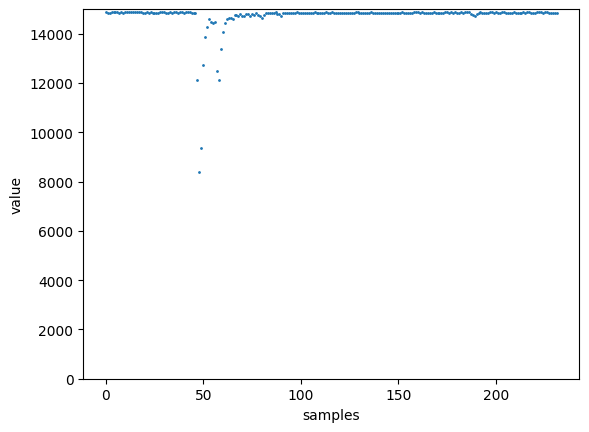

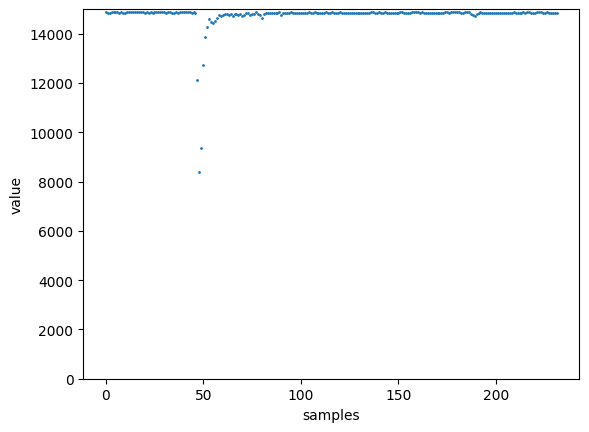

2021-10-01 08:58:38.687481: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


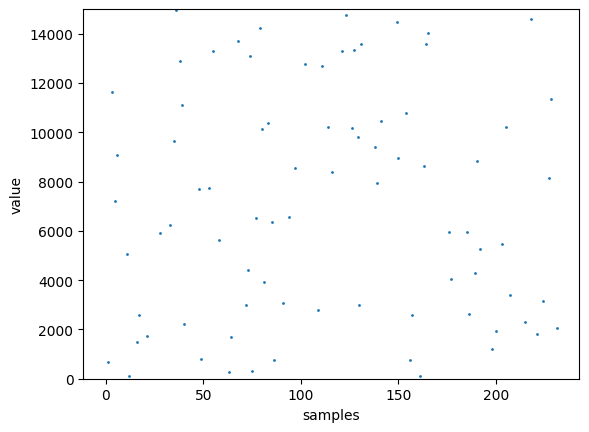

In [11]:
from matplotlib import colors

eventNumber = 232*100

fig = plt.figure()      
plt.xlabel("samples")
plt.ylabel("value")
plt.ylim(0,15000)
plt.scatter(np.array(range(232)),traceFinal[eventNumber].reshape(232), s=1)
plt.show()

fig = plt.figure()      
plt.xlabel("samples")
plt.ylabel("value")
plt.ylim(0,15000)
plt.scatter(np.array(range(232)),trace1[eventNumber].reshape(232), s=1)
plt.show()

result = model.predict(traceFinal[eventNumber].reshape(1,232,1))
fig = plt.figure()      
plt.xlabel("samples")
plt.ylabel("value")
plt.ylim(0,15000)
plt.scatter(np.array(range(232)),result.reshape(232), s=1)
plt.show()